In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import torch

from tqdm import tqdm_notebook as tqdm

In [2]:
plt.rcParams["font.family"] = 'DejaVu Sans'

plt.rcParams['text.usetex'] = True

In [3]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['font.size'] = 40

In [4]:
color = ['blue', 'red', 'black', 'black', 'black']

In [5]:
from MixtureLib.Mixture import MixtureEM
from MixtureLib.LocalModels import EachModelLinear
from MixtureLib.HyperModels import HyperExpertNN, HyperModelDirichlet

from MixtureLib.Regularizers import RegularizeModel

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [7]:
np.random.seed(0)
N = 100
n = 2

w1 = np.random.randn(n)
X1 = np.random.multivariate_normal(-3*np.ones(n), np.eye(n), size = N)

w2 = np.random.randn(n)
X2 = np.random.multivariate_normal(3*np.ones(n), np.eye(n), size = N)

X = np.vstack([X1, X2])

Y = np.hstack([X1@w1, X2@w2])
Y += 0.1*np.random.randn(*Y.shape)



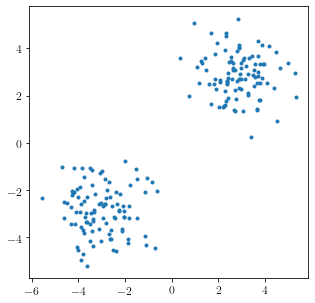

In [8]:
FONT_SIZE = 12

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['axes.titlesize']=FONT_SIZE
plt.rcParams['axes.labelsize']=FONT_SIZE
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['font.size'] = FONT_SIZE
##############################################

_ = plt.plot(X[:, 0], X[:, 1], '.')

In [9]:
W_true = np.array([w1, w2])

In [10]:
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([200, 2]), torch.Size([200, 1]))

# Simple Example Mixture of Experts

In [11]:
K = 2
epoch = 10

In [12]:
LIST_A = [torch.Tensor([1, 1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0.1], [0.1]]), torch.Tensor([[-0.1], [-0.1]])]

LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.eye(2)*LIST_A[k], w = torch.ones(2,1)*LIST_w[k]))

HypPar = {'beta': 1.0,}

HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)

model.fit(X_tr, Y_tr, epoch, progress = tqdm)


In [13]:
np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

array([[1.098052 , 0.649313 ],
       [1.7815475, 0.3811922]], dtype=float32)

In [14]:
W_true

array([[1.76405235, 0.40015721],
       [1.0996596 , 0.65526373]])

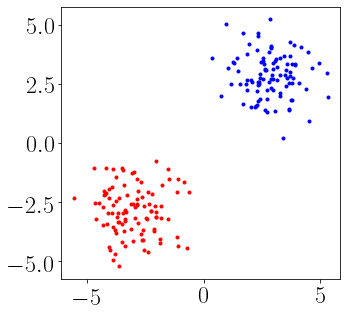

In [15]:
FONT_SIZE = 24

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['axes.titlesize']=FONT_SIZE
plt.rcParams['axes.labelsize']=FONT_SIZE
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['font.size'] = FONT_SIZE
##############################################

idx = np.argmax(model.predict(X_tr)[1], axis = 1)
for i in np.unique(idx):
    indexes = np.where(idx == i)
    _ = plt.plot(X[indexes, 0], X[indexes, 1], '.', color=color[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.show()

# Simple Example Mixture of Model

In [16]:
K = 2
epoch = 100

In [17]:
LIST_A = [torch.Tensor([1, 1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0.1], [0.1]]), torch.Tensor([[-0.1], [-0.1]])]

LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.eye(2)*LIST_A[k], w = torch.ones(2,1)*LIST_w[k]))

HypPar = {'beta': 1.0,}

HpMd = HyperModelDirichlet(output_dim = K, device = device)

model = MixtureEM(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)

model.fit(X_tr, Y_tr, epoch, progress = tqdm)


In [18]:
np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

array([[1.7816203 , 0.38085926],
       [1.0997782 , 0.6468744 ]], dtype=float32)

In [19]:
W_true

array([[1.76405235, 0.40015721],
       [1.0996596 , 0.65526373]])

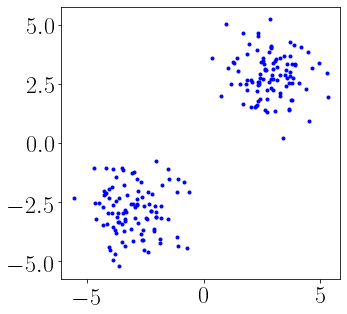

In [20]:
FONT_SIZE = 24

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['axes.titlesize']=FONT_SIZE
plt.rcParams['axes.labelsize']=FONT_SIZE
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['font.size'] = FONT_SIZE
##############################################

idx = np.argmax(model.predict(X_tr)[1], axis = 1)
for i in np.unique(idx):
    indexes = np.where(idx == i)
    _ = plt.plot(X[indexes, 0], X[indexes, 1], '.', color=color[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.show()